# Topic modeling example

This exercise introduces topic modeling using the LDA (Latent Dirichlet Allocation) algorithm and the Non-negative Matrix Factorisation (NMF) algorithm.

Topic modeling is an unsupervised approach that allows you to explore large text collections.

Written by: Sumithra Velupillai, with input from Sonia Priou, February 2019 

In [1]:
#! pip install numpy
#!pip install gensim
#!pip uninstall numpy

In [2]:
#!pip install numpy==1.19.3

In [3]:
#!pip install --upgrade numpy
# !pip install --upgrade gensim
# !pip install spacy==3.2.0
# !pip install gensim==3.9.5

In [1]:
# !pip install numpy==1.22.0

In [1]:
## First we need to import all the necessary packages

import string
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import itertools
import zipfile

try:
    import pyLDAvis
except ImportError as e:
    !pip install pyldavis
    import pyLDAvis

import pyLDAvis.gensim as gensimvis
import os
import pandas as pd

import re
import codecs
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings; warnings.simplefilter('ignore')

from datetime import datetime
print(datetime.now())

[nltk_data] Downloading package punkt to /Users/lilifang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilifang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


2023-03-07 11:17:58.911285


# 1: Functions for LDA and NMF

In [15]:
def get_tfidf_model(dataframe, text_column, min_df = 0.1, max_df=0.9):
    stopwords = nltk.corpus.stopwords.words('english')
    #new_stopwords = ["um", "ok", "oh", "okay", "yes","get","mhm","yeah","ah","uh","no","hm","wow"] "ok"
    new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','oop']
    #new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get","yeah","no","hm","wow",'.','?','-','--',':','mm']
    stopwords.extend(new_stopwords)
    # min_df = 0.01 means ignore terms that appear in less than 1% of the documents (This doesnot work in our codes)
    # max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
    # max_df = 25 means "ignore terms that appear in more than 25 documents".
    # min_df = 5 means "ignore terms that appear in less than 5 documents".
    # #     min_df = 50 # ()
    # #     max_df = 8500
    #min_df = 90 # ()
    min_df = 180 # ()
    max_df = 8976
    bow_transformer = CountVectorizer(stop_words=stopwords, 
                                  min_df=min_df, 
                                  max_df=max_df).fit(dataframe[text_column])
    document_bow = bow_transformer.transform(dataframe[text_column])
    feature_names = bow_transformer.get_feature_names()
    tfidf_transformer = TfidfTransformer().fit(document_bow)
    document_tfidf= tfidf_transformer.transform(document_bow)
    return feature_names, document_tfidf

In [3]:
def getNMFModel(no_topics, document_tfidf):
    nmf = NMF(n_components=no_topics, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, 
          init='nndsvd').fit(document_tfidf)

    W = nmf.transform(document_tfidf)
    H = nmf.components_
    return nmf, W, H

def getLDAModel(no_topics, document_tfidf):
    lda = LatentDirichletAllocation(n_components=no_topics).fit(document_tfidf)
    return lda

In [4]:
# We need a couple of functions to visualise the data
# Preparation for visualisation 
# Written by Sonia Priou, adaptations by Sumithra Velupillai

def display_topics(model, feature_names, no_top_words):
    topic_id_text_lis = [] 
    for topic_idx, topic in enumerate(model.components_):
        topic_id =topic_idx
        topic_keyword =" - ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(topic_id,topic_keyword)
        new_id_keywords = str(topic_id)+':'+topic_keyword
        topic_id_text_lis.append(new_id_keywords)
    return topic_id_text_lis

In [5]:

def get_topic_list(model, feature_names, no_top_words):
    tlist = {}
    for topic_idx, topic in enumerate(model.components_):
        tlist[topic_idx]= str("%d: " % (topic_idx)+", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return tlist

    
def display_topic_representation (model,dataframe,tlist):
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    num_topics = doc_topic.shape[1]
    dico = {'index': doc}
    for n in range(num_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        if len(set(doc_topic[i])) == 1:
            Topic_max.append(num_topics+1)
        else:
            Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    #print(Topic_max)
    tlist[num_topics+1] = 'NONE'
    dico["Topic and its most representative words"] = [tlist[x] for x in Topic_max]
    df_topic = pd.DataFrame(dico)

    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    df_result = df_result.sort_values('Topic most represented')
    
    #Finding within the cluster found by LDA the original file
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.set_style('whitegrid')
    sns.countplot(y='Topic and its most representative words', data = df_result)
    return df_result



In [6]:
def display_file_representation (model,dataframe):
    #Within a file, what is the slipt between topics found
    doc_topic = model    #example : model = lda_Tfidf.transform(tfidf)
    doc = np.arange(doc_topic.shape[0])
    no_topics = doc_topic.shape[1]
    topic = np.arange(no_topics)
    dico = {'index': doc}
    for n in range(no_topics):
        dico["topic" + str(n)] = doc_topic[:,n]
    #Max topic 
    Topic_max = []
    for i in range(doc_topic.shape[0]):
        Topic_max.append(doc_topic[i].argmax())
    dico["Topic most represented"] = Topic_max
    df_topic = pd.DataFrame(dico)
    #print(df_topic)
    
    
    #Link both DataFrame
    df_result = pd.merge(dataframe,df_topic, on='index')
    
    dico2 = {'Topic': topic}
    for i in df_result['label'].value_counts().index:
        ser = df_result.loc[df_result['label']==i].mean()
        score = ser[2:no_topics+2]
        dico2[i]=score

    df_score = pd.DataFrame(dico2)
    print('For each given file, we calculate the mean percentage of the documents depence to each topic')
    print('')
    print(df_score)
    print(df_result['label'].value_counts().index)

    fig, axs = plt.subplots(ncols=len(dataframe['label'].value_counts()))
    count = 0
    for i in df_result['label'].value_counts().index:
        sns.barplot(x='Topic', y =i ,data = df_score, ax=axs[count])
        count = count + 1
        
    plt.tight_layout()

In [7]:
def calculate_coherence( w2v_model, term_rankings , print_pairs=False):
        overall_coherence = 0.0
        for topic_index in range(len(term_rankings)):
            # check each pair of terms
            pair_scores = []
            for pair in combinations( term_rankings[topic_index], 2 ):
                ## check if word in vocabulary first!! Added by Sumithra
                if pair[0] in w2v_model.wv.index_to_key and pair[1] in w2v_model.wv.index_to_key:
                    pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
                    if print_pairs:
                        print(pair[0], pair[1], w2v_model.wv.similarity(pair[0], pair[1]))
                else:
                    if print_pairs:
                        print('word pair not in vocabulary', pair[0], pair[1])
                    pair_scores.append( 0.0 )
            # get the mean for all pairs in this topic
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score
        # get the mean score across all topics
        return overall_coherence / len(term_rankings)

In [8]:
 class TokenGenerator:
        def __init__( self, documents, stopwords ):
            self.documents = documents
            self.stopwords = stopwords
            self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

        def __iter__( self ):
            #print("Building Word2Vec model ...")
            for doc in self.documents:
                tokens = []
                for tok in self.tokenizer.findall( doc ):
                    if tok.lower() in self.stopwords:
                        tokens.append( "<stopword>" )
                    elif len(tok) >= 2:
                        tokens.append( tok.lower() )
                yield tokens


In [9]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

## Read data

In [41]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# read the data that we prepared for analysis
df = pd.read_csv('all_respones_for_all_interviewees_respones_LIWC_words_V2.csv')
print(df.shape)
print(df.columns)



(17953, 8)
Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'Nresponse', 'LIWC_response'],
      dtype='object')


In [11]:
print(17953/2)
print(17953*0.005)

8976.5
89.765


In [43]:
import re
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import string
import numpy as np
import pandas as pd

corpus = df['response']
# Initialize the CountVectorizer with the desired parameters
vectorizer = CountVectorizer(min_df=10, max_df=8976)

# Fit the vectorizer on the corpus to create a vocabulary
vectorizer.fit_transform(corpus)

# Get the vocabulary of the vectorizer
vocabulary = vectorizer.get_feature_names()


def clean_text(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()
    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = stopwords.words('english')
    
    new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','oop']
    #new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get","yeah","no","hm","wow",'.','?','-','--',':','mm']
    stopwords_list.extend(new_stopwords)
    
    # puctuation
    punct = set(string.punctuation)
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    # remove punctuation
    word_list = [word for word in word_list if word not in punct] 
    
    # Define the corpus of documents as a list of strings
   
    word_list = [word for word in word_list if word in vocabulary]
    # stemming
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    sentence = ' '.join(word_list)   
    return sentence


In [39]:
def clean_text2(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()
    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = stopwords.words('english')
    
    new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','oop']
    #new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get","yeah","no","hm","wow",'.','?','-','--',':','mm']
    stopwords_list.extend(new_stopwords)
    
    # puctuation
    punct = set(string.punctuation)
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    # remove punctuation
    word_list = [word for word in word_list if word not in punct] 
    
    # Define the corpus of documents as a list of strings

    # stemming
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    sentence = ' '.join(word_list)   
    return sentence

In [18]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [46]:
df['sep_response']=df['response'].str.lower().apply(lambda x: word_tokenize(x))
# porter_stemmer = PorterStemmer()
df['response_lemar'] = df['response'].apply(lambda x: clean_text2(str(x)))
# df['response_stem'] = df['response_stem'].apply(lambda x: ' '.join(x))

In [44]:
# # display(df['response_stem'].head())
df['new_response'] = df['response'].progress_apply(lambda x: clean_text(str(x)))

  0%|          | 0/17953 [00:00<?, ?it/s]

In [47]:
df['words_count'] = df['response_lemar'].str.split().str.len()

In [48]:
ndf = df[df['words_count'] >0]
print(ndf.shape)

(14812, 12)


In [49]:
display(ndf.head())

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,new_response,sep_response,response_lemar,words_count
3,3,ASD.ADHD,Activity Three,974_16_06_2022,[00:01:08],Just says like,True,says,say like,"[just, says, like]",say like,2
4,4,ASD.ADHD,Activity Three,974_16_06_2022,[00:01:18],Okay. There's something you said. Something,True,something you,something said something,"[okay, ., there, 's, something, you, said, ., ...",something said something,3
7,7,ASD.ADHD,Icebreaker,974_16_06_2022,[00:03:16],Just my mum so --,True,mum,mum,"[just, my, mum, so, --]",mum,1
9,9,ASD.ADHD,Icebreaker,974_16_06_2022,[00:04:16],With the picture cause I had to rush cause I ...,True,picture didn't thought but couldn't wanted,picture cause rush cause forgot like like thou...,"[with, the, picture, cause, i, had, to, rush, ...",picture cause rush cause forgot like like thou...,12
11,11,ASD.ADHD,Icebreaker,974_16_06_2022,[00:04:47],I do dance on Saturday I do singing at home e...,True,dance singing every since every,home every day done drawing since read every d...,"[i, do, dance, on, saturday, i, do, singing, a...",dance saturday singing home every day done dra...,13


## NMF model and the corresponding results

In [101]:
#!pip install --upgrade gensim

In [50]:
# df =df.dropna(subset='LIWC_response')
ndf['index'] = range(0,len (ndf))
# Compute coherence score 
import gensim
kmin, kmax = 7, 25
feature_names, document_tfidf = get_tfidf_model(ndf, 'response_lemar')
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    #print("Applying NMF for k=%d ..." % k )
    # run NMF
    #model = decomposition.NMF( init="nndsvd", n_components=k ) 
    model = decomposition.NMF(n_components=k, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.5, init='nndsvd') # , init='nndsvd'
    W = model.fit_transform(document_tfidf )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )
    
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get",'yep',"yeah","no","hm","wow",'.','?','-','--',':','mm','oop']
# new_stopwords = ["um", "oh", "okay", "mhm","ah","uh","yes","get","yeah","no","hm","wow",'.','?','-','--',':','mm']
# new_stopwords =  ["um", "ok", "oh", "okay", "mhm","ah","uh","hm","wow",'.','?','-','--',':','mm']
stopwords.extend(new_stopwords)
docgen = TokenGenerator(df['response_lemar'], stopwords)
# docgen = TokenGenerator(df['response'])
print(docgen)

w2v_model = gensim.models.Word2Vec(docgen, min_count=20, sg=1)
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(feature_names, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append(calculate_coherence( w2v_model, term_rankings ) ) # 
    #print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) ) 
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
print(best_k)

12


In [51]:
# import gensim
# print(gensim.__version__)
# #pycaret 2.3.10 requires gensim<4.0.0, but you have gensim 4.0.0 which is incompatible.


In [52]:
#!pip install gensim==4.0.0

0 like - stuff - kind - mean - got - anything - said - want - would - people - going - person - minute - school - talking
1 really - anything - much - sure - mind - nothing - angry - excited - annoyed - find - want - talk - emotion - kind - understand
2 think - anything - actually - situation - might - sure - trying - day - kind - need - else - done - thinking - better - going
3 feel - make - happy - better - angry - calm - feeling - emotion - anything - quite - want - good - way - stressed - upset
4 know - going - actually - mean - kind - people - want - work - guess - stuff - change - trying - always - need - tell
5 one - first - two - last - want - many - friend - day - got - teacher - right - actually - even - see - little
6 sometimes - angry - want - try - tell - start - depends - might - annoyed - guess - lesson - find - annoying - ask - stop
7 well - kind - still - end - getting - want - actually - teacher - thought - might - help - usually - going - mean - back
8 something - el

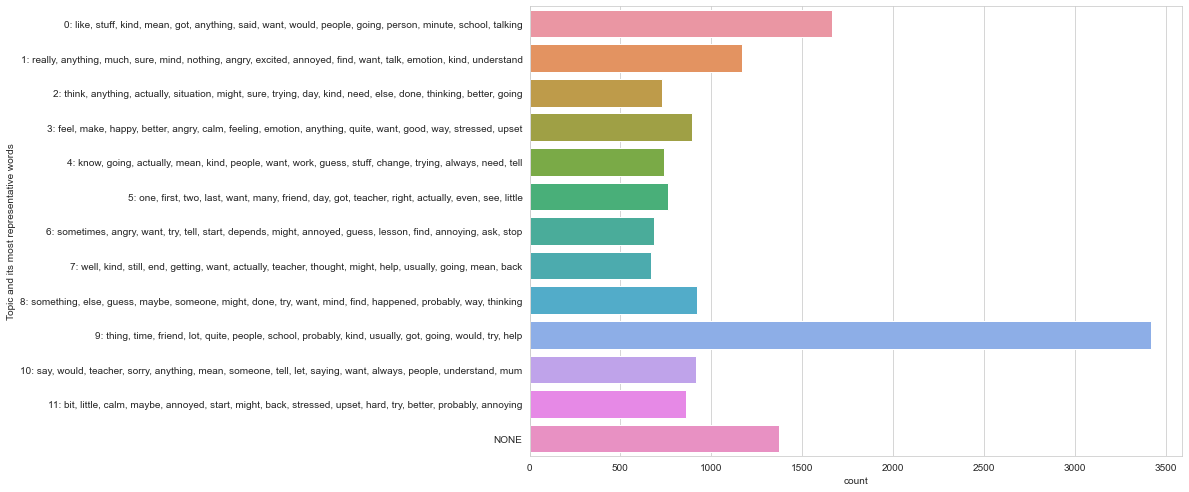

In [53]:
## let's see if the models produce something coherent with the best_k number
no_topics = best_k
#no_topics = 12
## Each topic is represented with a list of words, ranked according to how discriminative they are for that topic. 
## We can use the top ranked words to try to understand what the topic represents.
no_top_words = 15
#lda = getLDAModel(no_topics, document_tfidf)
nmf, W, H = getNMFModel(no_topics, document_tfidf)
result1= display_topics(nmf, feature_names, no_top_words) 
#new_file.write(str(best_k)+','+str(result1)+'\n')
print('Representation of the main topic for each document')
tlist = get_topic_list(nmf,feature_names, no_top_words)
df_result = display_topic_representation(W,ndf,tlist)

In [54]:
df_result.head()

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,new_response,sep_response,...,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,Topic most represented,Topic and its most representative words
3167,3682,ASD.ADHD,Activity Two,145_12_05_2022,[00:53:20],Because because if I just show myself who I a...,True,because if show who actually might bad or,show actually might put like bad,"[because, because, if, i, just, show, myself, ...",...,0.001523,0.000418,0.000942,0.000613,0.004430,0.004916,0.000000,0.001449,0,"0: like, stuff, kind, mean, got, anything, sai..."
2271,2636,ASD.ADHD,Icebreaker,926_05_07_2022,[00:06:31],Well like if I've got a piece of paper and th...,True,if lot can't can't can't because,well like got piece paper like lot writing lik...,"[well, like, if, i, 've, got, a, piece, of, pa...",...,0.030196,0.000000,0.000000,0.035574,0.000000,0.013941,0.000000,0.000000,0,"0: like, stuff, kind, mean, got, anything, sai..."
11688,14139,ASD,Activity Three,006_04_05_2022,[00:37:50],Well I usually would like if it was someone l...,True,usually would if someone friends but if someon...,well usually would like someone like friend so...,"[well, i, usually, would, like, if, it, was, s...",...,0.000000,0.000000,0.001391,0.012830,0.006793,0.020927,0.006123,0.000000,0,"0: like, stuff, kind, mean, got, anything, sai..."
11686,14137,ASD,Activity Three,006_04_05_2022,[00:36:57],Yeah some things. Like if I like if I tell m...,True,some if if tell friend,thing like like tell friend like,"[yeah, some, things, ., like, if, i, like, if,...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.031151,0.000000,0.000000,0,"0: like, stuff, kind, mean, got, anything, sai..."
11679,14130,ASD,Activity Three,006_04_05_2022,[00:34:40],I would usually like talk to someone or just ...,True,would usually talk someone or ignore,would usually like talk someone ignore,"[i, would, usually, like, talk, to, someone, o...",...,0.000000,0.000000,0.000000,0.000000,0.003039,0.017528,0.006365,0.000000,0,"0: like, stuff, kind, mean, got, anything, sai..."


In [55]:
df_result.tail()

,ids,diagnosis,section,pilot_number,inter_time,response,Nresponse,LIWC_response,new_response,sep_response,...,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,Topic most represented,Topic and its most representative words
2569,3003,ASD.ADHD,Activity Two,199_02_07_2022,[00:40:27],Oh the second row.,True,NaN,second row,"[oh, the, second, row, .]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,NONE
4495,5249,ADHD,Feedback,969_04_07_2022,[01:33:24],Um with my family yes because they're used ...,True,family because they're used,family used,"[um, with, my, family, yes, because, they, 're...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,NONE
8939,10601,ADHD,Activity Two,050_31_03_2022,[00:12:01],It bores me.,False,NaN,,"[it, bores, me, .]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,NONE
998,1174,ASD.ADHD,Activity Two,199_02_07_2022,[00:28:27],Oh I can hear you now yeah.,True,hear you,hear,"[oh, i, can, hear, you, now, yeah, .]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,NONE
8921,10574,ADHD,Activity One,050_31_03_2022,[00:03:59],Scones.,False,NaN,,"[scones, .]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,NONE


In [56]:
print(df_result.columns)

Index(['ids', 'diagnosis', 'section', 'pilot_number', 'inter_time', 'response',
       'Nresponse', 'LIWC_response', 'new_response', 'sep_response',
       'response_lemar', 'words_count', 'index', 'topic0', 'topic1', 'topic2',
       'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
       'topic10', 'topic11', 'Topic most represented',
       'Topic and its most representative words'],
      dtype='object')


In [57]:
print(df_result.shape) # 17953

(14812, 27)


In [60]:
new_result = new_result[new_result['new_response'] !='NONE']
print(new_result.shape)

(13439, 27)


In [67]:
newdf2 = new_result[['ids', 'diagnosis','section', 'pilot_number', 'inter_time', 'response', 'response_lemar','new_response','Topic most represented', 'Topic and its most representative words']]

In [76]:
newdf2=newdf2.dropna(subset='new_response')
print(newdf2.shape) # (13435, 10)

In [68]:
newdf2.to_excel('All interviewees responses and the corresponding representative words_withoutNONE_updatedV14.xlsx',index=False)

In [69]:
newdf2.to_csv('All interviewees responses and the corresponding representative words_withoutNONE_updatedV14.csv',index=False)

In [70]:
display(newdf2.tail())

,ids,diagnosis,section,pilot_number,inter_time,response,response_lemar,new_response,Topic most represented,Topic and its most representative words
2405,2797,ASD.ADHD,Activity One,926_05_07_2022,[01:00:09],Just if I can't calm myself down.,calm,calm,11,"11: bit, little, calm, maybe, annoyed, start, ..."
6691,7886,ADHD,Activity Four,175_27_04_2022,[01:13:40],A lot because she broke one of my rules. When...,lot broke one rule little sister lived togethe...,lot broke one rule little sister together worl...,11,"11: bit, little, calm, maybe, annoyed, start, ..."
10127,12138,ASD,Activity Three,Pilot66_28_02_2022,[00:18:18],Sometimes I get a bit angry.,sometimes bit angry,sometimes bit angry,11,"11: bit, little, calm, maybe, annoyed, start, ..."
1370,1609,ASD.ADHD,Activity One,144_11_05_2022,[02:03:07],Until I sat -- imagine the sport hall here. I ...,sat imagine sport hall walked went around litt...,sat imagine sport walked went around little bi...,11,"11: bit, little, calm, maybe, annoyed, start, ..."
6092,7174,ADHD,Activity Two,089_11_04_2022,[00:11:18],I start to feel less calm. I feel a bit agitat...,start feel le calm feel bit agitated start lik...,start feel le calm feel bit agitated start lik...,11,"11: bit, little, calm, maybe, annoyed, start, ..."
